In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import tensorflow as tf
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Function to calculate RSI
def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Create target for classification: 1 (up), 0 (same), -1 (down)
def create_direction_target(df, lookahead=10, threshold=0.1):
    future_prices = df['close'].shift(-lookahead)
    price_diff = future_prices - df['close']
    
    # Create direction labels:
    # 1 means price went up by at least threshold
    # 0 means price stayed within threshold
    # -1 means price went down by at least threshold
    direction = np.zeros(len(df))
    direction[price_diff >= threshold] = 1
    direction[price_diff <= -threshold] = -1
    
    return direction

# Create sequences for LSTM (regression)
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length - 10):
        # Input sequence
        x = data[i:(i + seq_length)]
        # Next 10 minutes as target for regression
        y = data[(i + seq_length):(i + seq_length + 10), 3]  # 3 is the index of close price
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Create sequences for classification
def create_class_sequences(data, labels, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        # The label is the direction after the sequence
        y = labels[i + seq_length - 1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Function to visualize confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
print("Helper functions defined!")

Helper functions defined!


In [3]:
# Load the data
df = pd.read_csv('nvda_180_days_minute_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

print(f"Data loaded successfully! Shape: {df.shape}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print("\nFirst few rows of the data:")
print(df.head())

# Create additional features
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute
df['day_of_week'] = df['timestamp'].dt.dayofweek  # Monday=0, Sunday=6

# Calculate some technical indicators
df['price_change'] = df['close'].pct_change()
df['rolling_mean_5'] = df['close'].rolling(window=5).mean()
df['rolling_std_5'] = df['close'].rolling(window=5).std()
df['upper_band'] = df['rolling_mean_5'] + (df['rolling_std_5'] * 2)
df['lower_band'] = df['rolling_mean_5'] - (df['rolling_std_5'] * 2)
df['rsi_5'] = calculate_rsi(df['close'], window=5)
df['volume_change'] = df['volume'].pct_change()

# Drop NaNs created by technical indicators
df = df.dropna()

print(f"\nData after feature engineering. Shape: {df.shape}")
print("\nFeatures overview:")
print(df.describe().T)

Data loaded successfully! Shape: (115234, 7)
Date range: 2024-11-13 09:00:00 to 2025-05-09 23:59:00

First few rows of the data:
  symbol           timestamp    open    high     low   close   volume
0   NVDA 2024-11-13 09:00:00  148.65  148.95  148.00  148.50  14930.0
1   NVDA 2024-11-13 09:01:00  148.47  148.57  148.40  148.53   7825.0
2   NVDA 2024-11-13 09:02:00  148.55  148.56  148.41  148.48  11155.0
3   NVDA 2024-11-13 09:03:00  148.49  148.49  148.25  148.27  15815.0
4   NVDA 2024-11-13 09:04:00  148.23  148.26  148.10  148.15  12117.0

Data after feature engineering. Shape: (115228, 17)

Features overview:
                   count                           mean                  min  \
timestamp         115228  2025-02-12 03:35:15.376471040  2024-11-13 09:04:00   
open            115228.0                     125.601775                86.27   
high            115228.0                     125.682616              87.3499   
low             115228.0                     125.516616   

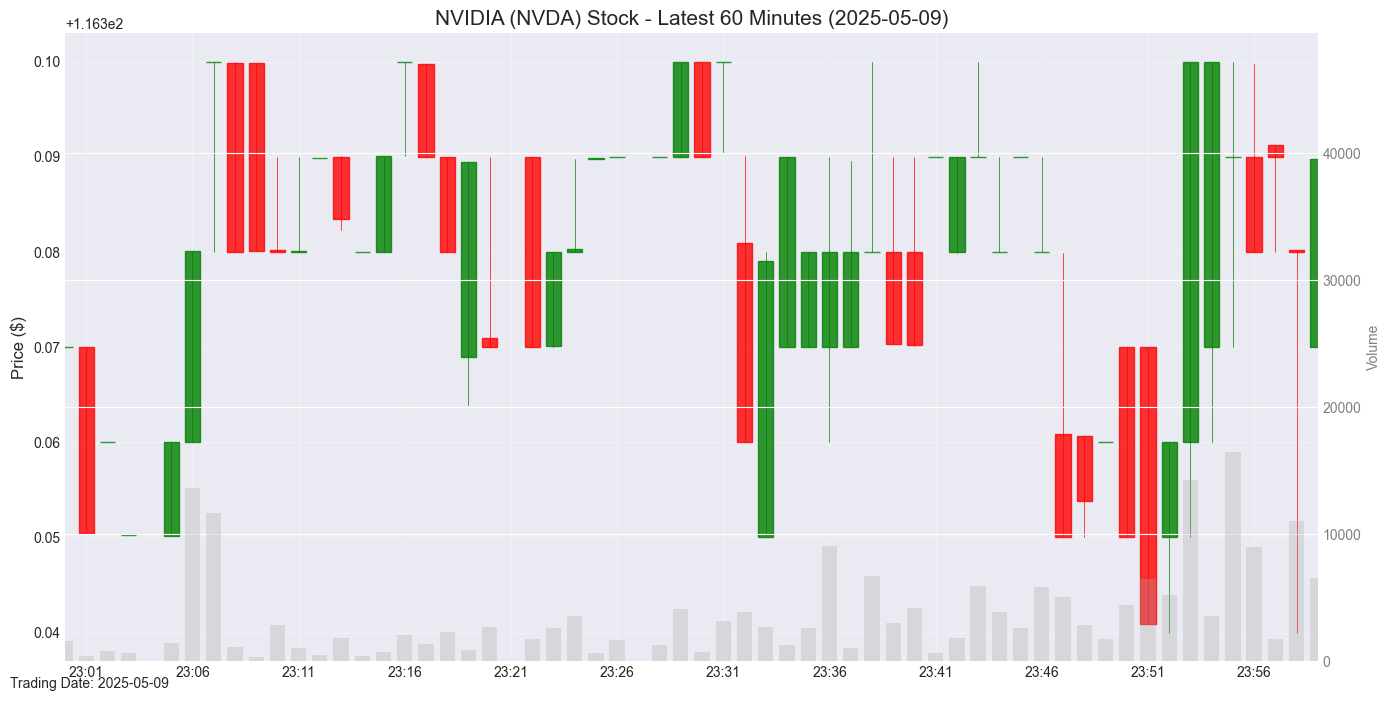

In [5]:
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc


# Filter the dataframe to include only the latest 60 minutes
latest_timestamp = df['timestamp'].max()
start_timestamp = latest_timestamp - pd.Timedelta(minutes=59)  # 59 + the latest minute = 60 minutes
latest_data = df[(df['timestamp'] >= start_timestamp) & (df['timestamp'] <= latest_timestamp)]

# Create a figure
plt.figure(figsize=(14, 7))

# Prepare data for candlestick chart
ohlc = latest_data[['timestamp', 'open', 'high', 'low', 'close']].copy()
ohlc['timestamp'] = mdates.date2num(ohlc['timestamp'].values)
ohlc = ohlc.values

# Create the candlestick chart
ax1 = plt.subplot(111)
candlestick_ohlc(ax1, ohlc, width=0.0005, colorup='green', colordown='red', alpha=0.8)

# Add volume as a bar chart at the bottom with a separate y-axis
ax2 = ax1.twinx()
ax2.bar(mdates.date2num(latest_data['timestamp'].values), latest_data['volume'], 
        width=0.0005, color='darkgray', alpha=0.3)
ax2.set_ylabel('Volume', color='gray')
ax2.tick_params(axis='y', colors='gray')
ax2.set_ylim(0, latest_data['volume'].max() * 3)

# Format x-axis with more detailed time format for minute data
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))  # Show tick every 5 minutes
plt.xticks(rotation=45)

# Set title and labels
time_str = latest_timestamp.strftime('%Y-%m-%d')
plt.title(f'NVIDIA (NVDA) Stock - Latest 60 Minutes ({time_str})', fontsize=15)
ax1.set_ylabel('Price ($)', fontsize=12)
ax1.grid(True, alpha=0.3)

# Add a text annotation showing the date
trading_date = latest_timestamp.strftime('%Y-%m-%d')
plt.figtext(0.01, 0.01, f'Trading Date: {trading_date}', fontsize=10)

# Make sure everything fits
plt.tight_layout()

# Ensure x-axis limits are set correctly for the 60-minute window
ax1.set_xlim(mdates.date2num(start_timestamp), mdates.date2num(latest_timestamp))

plt.show()

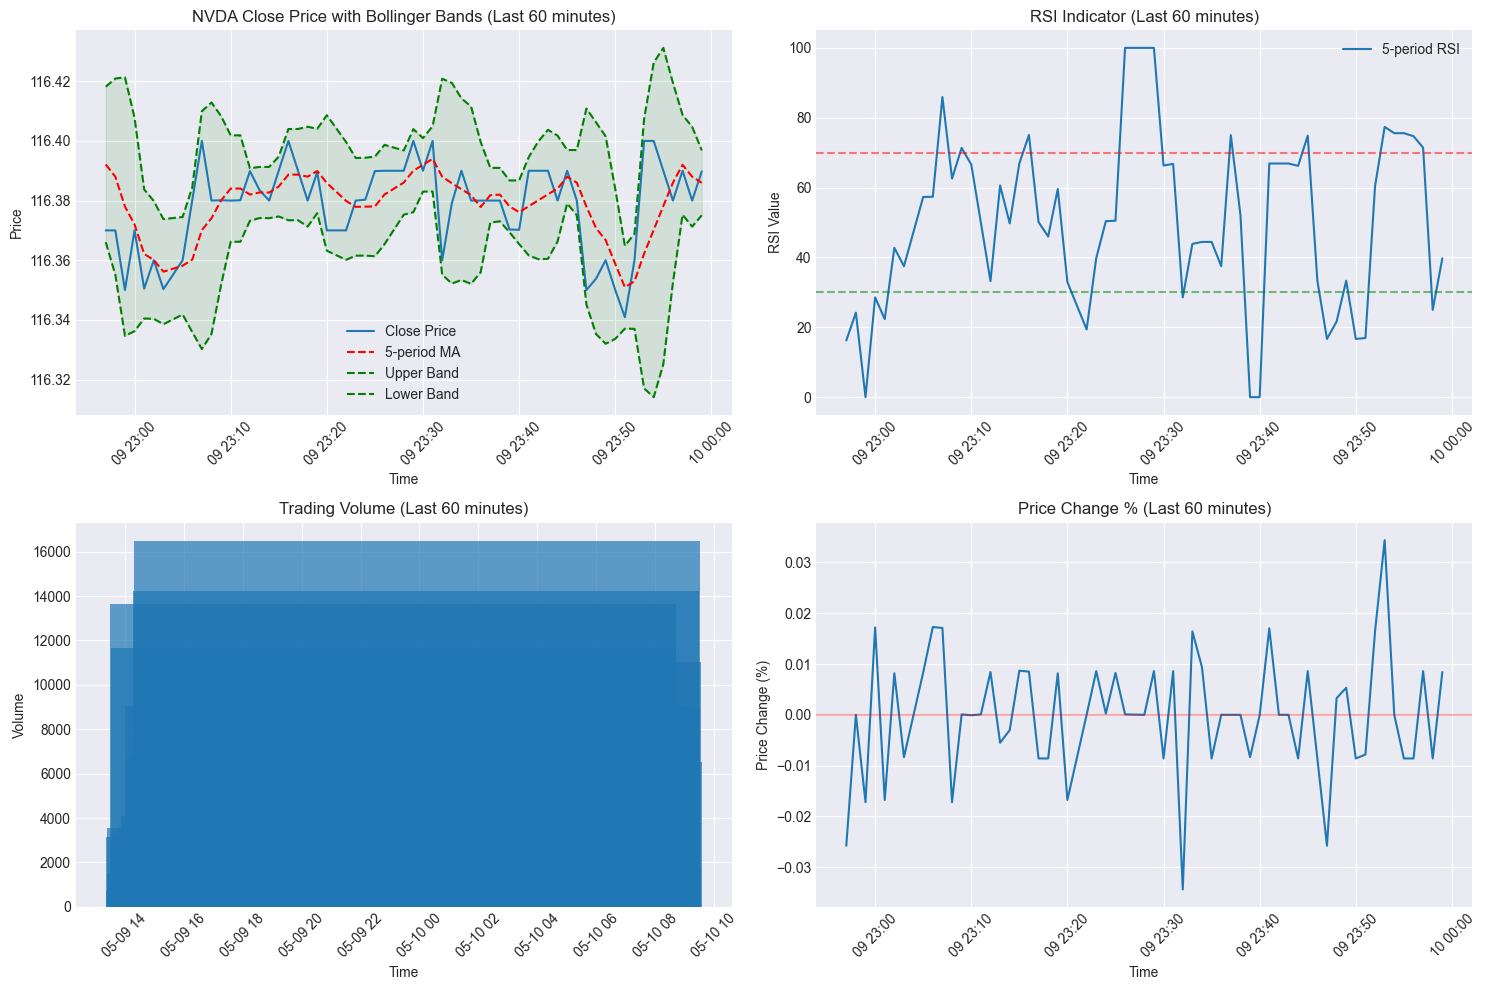

Technical indicators for the last 60 minutes visualized!


In [7]:
# Visualize some of the technical indicators
plt.figure(figsize=(15, 10))

# Plot 1: Close Price with Bollinger Bands
plt.subplot(2, 2, 1)
plt.plot(df['timestamp'].iloc[-60:], df['close'].iloc[-60:], label='Close Price')
plt.plot(df['timestamp'].iloc[-60:], df['rolling_mean_5'].iloc[-60:], 'r--', label='5-period MA')
plt.plot(df['timestamp'].iloc[-60:], df['upper_band'].iloc[-60:], 'g--', label='Upper Band')
plt.plot(df['timestamp'].iloc[-60:], df['lower_band'].iloc[-60:], 'g--', label='Lower Band')
plt.fill_between(df['timestamp'].iloc[-60:], df['upper_band'].iloc[-60:], df['lower_band'].iloc[-60:], alpha=0.1, color='green')
plt.title('NVDA Close Price with Bollinger Bands (Last 60 minutes)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)

# Plot 2: RSI
plt.subplot(2, 2, 2)
plt.plot(df['timestamp'].iloc[-60:], df['rsi_5'].iloc[-60:], label='5-period RSI')
plt.axhline(y=70, color='r', linestyle='--', alpha=0.5)
plt.axhline(y=30, color='g', linestyle='--', alpha=0.5)
plt.title('RSI Indicator (Last 60 minutes)')
plt.xlabel('Time')
plt.ylabel('RSI Value')
plt.legend()
plt.xticks(rotation=45)

# Plot 3: Volume
plt.subplot(2, 2, 3)
plt.bar(df['timestamp'].iloc[-60:], df['volume'].iloc[-60:], alpha=0.7)
plt.title('Trading Volume (Last 60 minutes)')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.xticks(rotation=45)

# Plot 4: Price Change Percentage
plt.subplot(2, 2, 4)
plt.plot(df['timestamp'].iloc[-60:], df['price_change'].iloc[-60:] * 100)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title('Price Change % (Last 60 minutes)')
plt.xlabel('Time')
plt.ylabel('Price Change (%)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("Technical indicators for the last 60 minutes visualized!")

Class distribution:
direction
 0.0    42077
 1.0    36682
-1.0    36469
Name: count, dtype: int64
Percentage distribution: direction
 0.0    36.516298
 1.0    31.834276
-1.0    31.649425
Name: count, dtype: float64


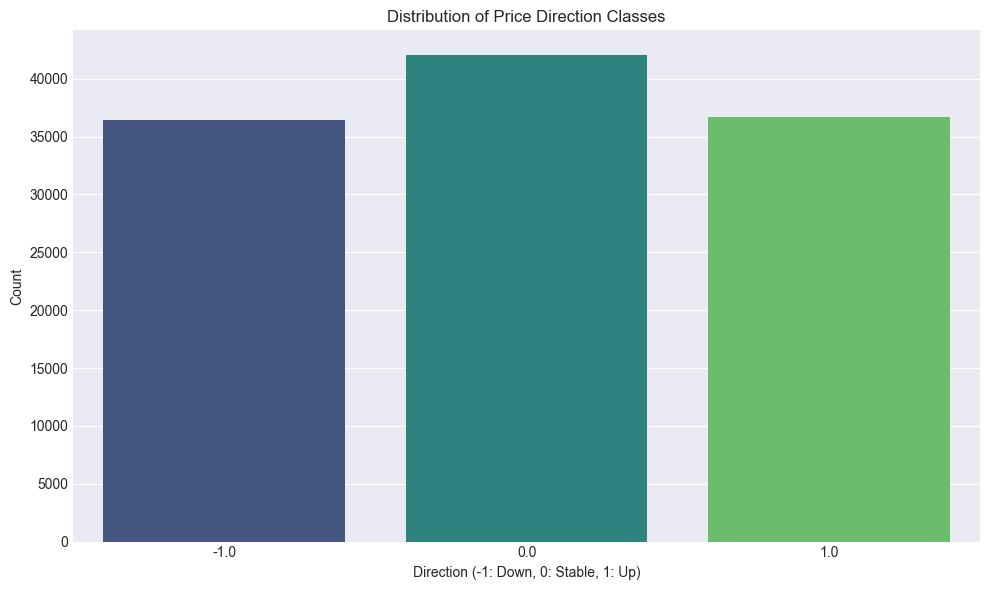

In [5]:
# Create the target variable for classification
df['direction'] = create_direction_target(df, lookahead=10, threshold=0.1)

# Drop rows where we can't determine the future direction (at the end of dataset)
df = df.dropna()

# Features for model training
feature_columns = ['open', 'high', 'low', 'close', 'volume', 
                   'hour', 'minute', 'day_of_week', 
                   'price_change', 'rolling_mean_5', 'rolling_std_5',
                   'rsi_5', 'volume_change']

# Check class distribution
class_counts = df['direction'].value_counts()
print("Class distribution:")
print(class_counts)
print(f"Percentage distribution: {class_counts / len(df) * 100}")

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='direction', data=df, palette='viridis')
plt.title('Distribution of Price Direction Classes')
plt.xlabel('Direction (-1: Down, 0: Stable, 1: Up)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [6]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[feature_columns].values)
price_scaler = MinMaxScaler(feature_range=(0, 1))
price_data = price_scaler.fit_transform(df[['close']].values)

# Sequence length (how many minutes to look back)
seq_length = 30

# Create sequences for regression (next 10 minutes prediction)
X_reg, y_reg = create_sequences(scaled_data, seq_length)

# Create sequences for classification
X_class, y_class = create_class_sequences(scaled_data, df['direction'].values, seq_length)

# Split data into train/test
train_split = int(0.8 * len(X_reg))
X_train_reg, X_test_reg = X_reg[:train_split], X_reg[train_split:]
y_train_reg, y_test_reg = y_reg[:train_split], y_reg[train_split:]

train_split_class = int(0.8 * len(X_class))
X_train_class, X_test_class = X_class[:train_split_class], X_class[train_split_class:]
y_train_class, y_test_class = y_class[:train_split_class], y_class[train_split_class:]

# Convert classification labels to one-hot encoding
y_train_class_cat = tf.keras.utils.to_categorical(y_train_class + 1, num_classes=3)
y_test_class_cat = tf.keras.utils.to_categorical(y_test_class + 1, num_classes=3)

print("Data preparation complete!")
print(f"Regression training data shape: {X_train_reg.shape}")
print(f"Regression test data shape: {X_test_reg.shape}")
print(f"Classification training data shape: {X_train_class.shape}")
print(f"Classification test data shape: {X_test_class.shape}")

Data preparation complete!
Regression training data shape: (92150, 30, 13)
Regression test data shape: (23038, 30, 13)
Classification training data shape: (92158, 30, 13)
Classification test data shape: (23040, 30, 13)


In [14]:
from keras.layers import Bidirectional
# Build LSTM model for regression (predicting next 10 minutes)
def build_regression_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(50))
    model.add(Dense(10))  # Output the next 10 minutes
    
    model.compile(optimizer='adam', loss='mse')
    return model

# Initialize and train regression model with early stopping
reg_model = build_regression_model((X_train_reg.shape[1], X_train_reg.shape[2]))

# Add early stopping for better convergence
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Training regression model...")
reg_history = reg_model.fit(
    X_train_reg, y_train_reg,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

print("Regression model training complete!")

Training regression model...
Epoch 1/20
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 74s 31ms/step - loss: 0.0079 - val_loss: 6.2879e-05
Epoch 2/20
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 71s 31ms/step - loss: 1.8218e-04 - val_loss: 3.6904e-05
Epoch 3/20
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 71s 31ms/step - loss: 1.5575e-04 - val_loss: 3.8584e-05
Epoch 4/20
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 71s 31ms/step - loss: 1.5703e-04 - val_loss: 2.0901e-04
Epoch 5/20
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 70s 30ms/step - loss: 1.4981e-04 - val_loss: 9.0735e-05
Epoch 6/20
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 71s 31ms/step - loss: 1.4609e-04 - val_loss: 1.2746e-04
Epoch 7/20
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 77s 33ms/step - loss: 1.3517e-04 - val_loss: 2.8268e-04
Epoch 8/20
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 74s 32ms/step - loss: 1.3766e-04 - val_loss: 7.7267e-05
Epoch 9/20
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 72s 31ms/step - loss: 1.2298e-04 - val_loss: 1.2926e-04
Epoch 10/20
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 72s 31ms/step - loss: 1.2404e-04 - val_loss: 1.854

720/720 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step
Regression Model Overall RMSE: 0.5091
RMSE for each prediction minute:
  Minute 1: 0.3581
  Minute 2: 0.4037
  Minute 3: 0.4516
  Minute 4: 0.4591
  Minute 5: 0.5067
  Minute 6: 0.5504
  Minute 7: 0.5563
  Minute 8: 0.5592
  Minute 9: 0.5789
  Minute 10: 0.6072


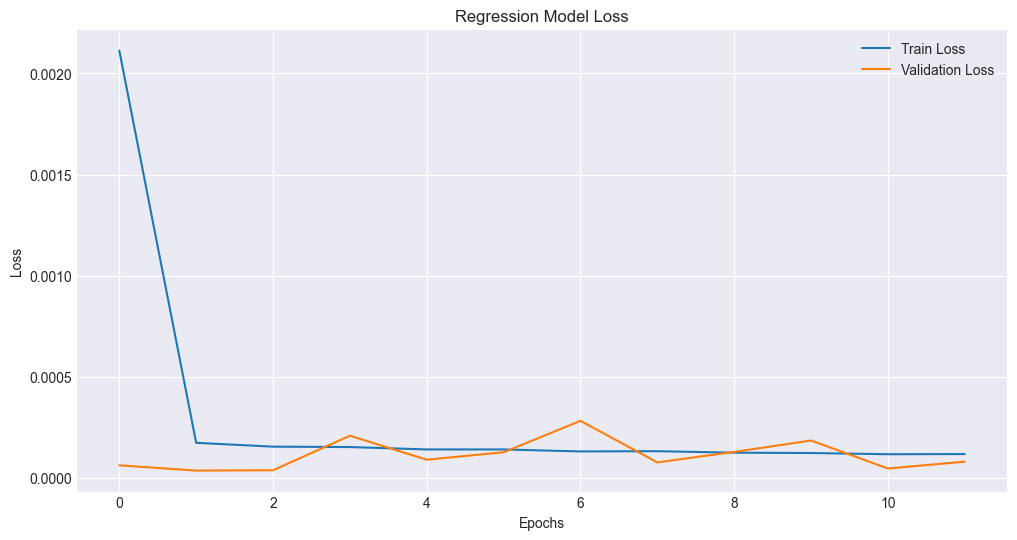

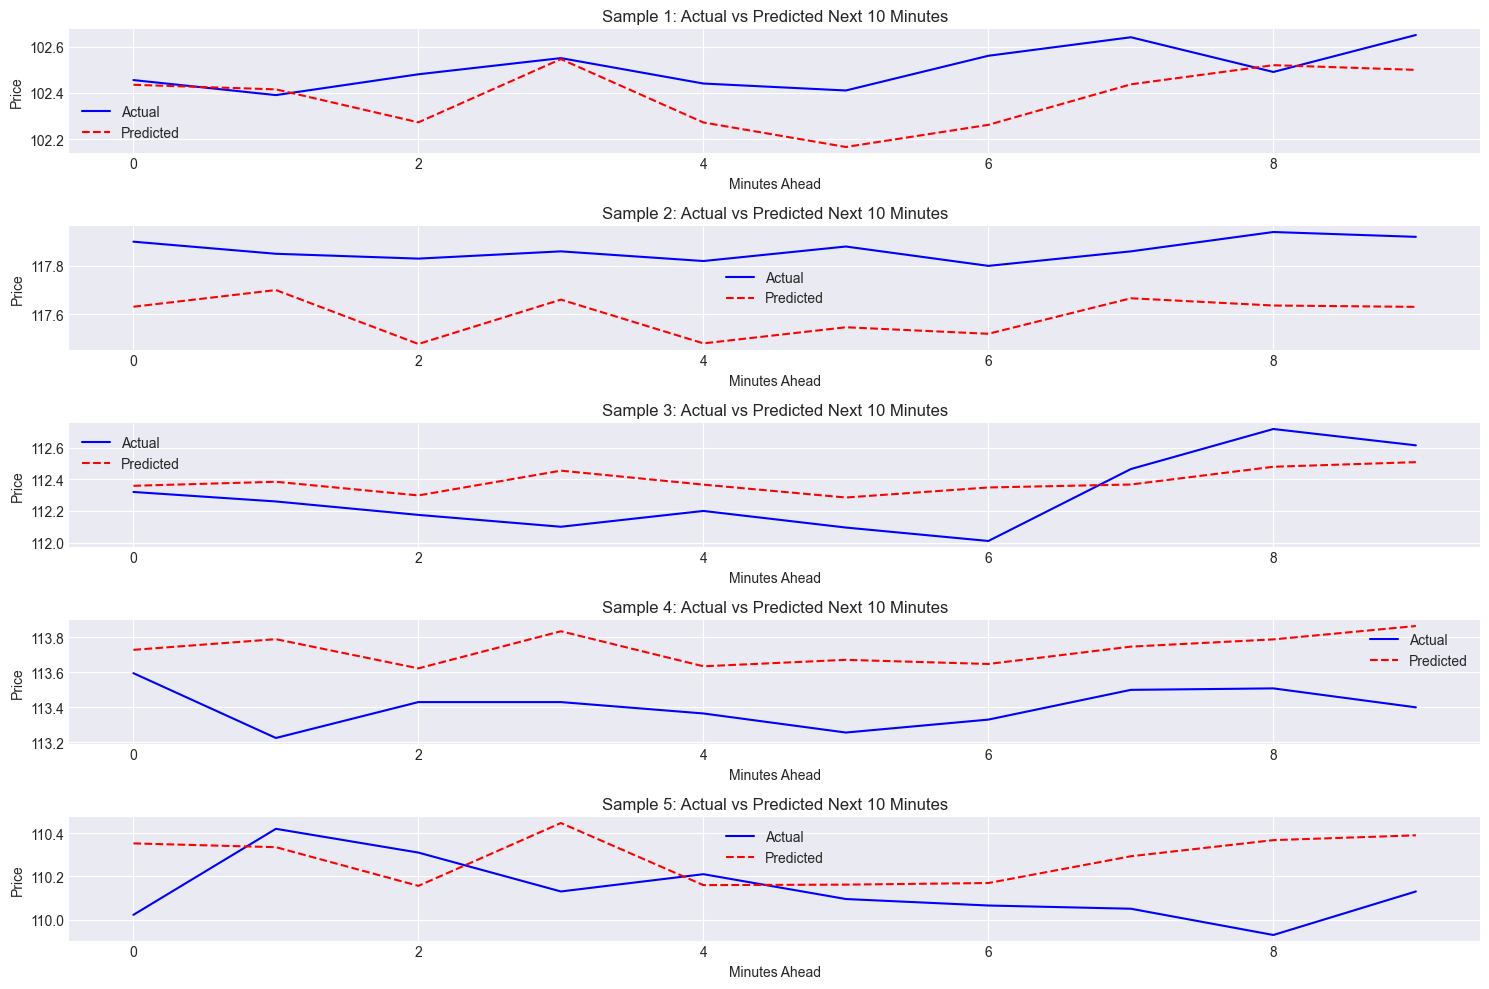

In [15]:
# Evaluate regression model
reg_preds = reg_model.predict(X_test_reg)

# Transform predictions and actual values back to original scale
reg_preds_actual = np.zeros((reg_preds.shape[0], reg_preds.shape[1]))
y_test_actual = np.zeros((y_test_reg.shape[0], y_test_reg.shape[1]))

for i in range(reg_preds.shape[0]):
    reg_preds_actual[i] = price_scaler.inverse_transform(reg_preds[i].reshape(-1, 1)).flatten()
    y_test_actual[i] = price_scaler.inverse_transform(y_test_reg[i].reshape(-1, 1)).flatten()

# Calculate RMSE for each time step
rmse_per_step = np.sqrt(np.mean((y_test_actual - reg_preds_actual)**2, axis=0))
mse = mean_squared_error(y_test_actual.flatten(), reg_preds_actual.flatten())
rmse = np.sqrt(mse)

print(f"Regression Model Overall RMSE: {rmse:.4f}")
print("RMSE for each prediction minute:")
for i, step_rmse in enumerate(rmse_per_step):
    print(f"  Minute {i+1}: {step_rmse:.4f}")

# Plot regression model loss
plt.figure(figsize=(12, 6))
plt.plot(reg_history.history['loss'], label='Train Loss')
plt.plot(reg_history.history['val_loss'], label='Validation Loss')
plt.title('Regression Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Visualize actual vs predicted for a sample
sample_idx = np.random.randint(0, len(y_test_actual), size=5)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(sample_idx):
    plt.subplot(len(sample_idx), 1, i+1)
    plt.plot(range(10), y_test_actual[idx], 'b-', label='Actual')
    plt.plot(range(10), reg_preds_actual[idx], 'r--', label='Predicted')
    plt.title(f'Sample {i+1}: Actual vs Predicted Next 10 Minutes')
    plt.xlabel('Minutes Ahead')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:
def build_classification_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # 3 classes: up, same, down
    
    # Use a fixed learning rate instead of a scheduler
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize and train classification model with early stopping
class_model = build_classification_model((X_train_class.shape[1], X_train_class.shape[2]))

# Add early stopping and reduce learning rate on plateau
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

print("Training classification model...")
class_history = class_model.fit(
    X_train_class, y_train_class_cat,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("Classification model training complete!")

Training classification model...
Epoch 1/20
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 83s 34ms/step - accuracy: 0.4107 - loss: 1.0654 - val_accuracy: 0.4328 - val_loss: 1.0285 - learning_rate: 0.0010
Epoch 2/20
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 80s 35ms/step - accuracy: 0.4602 - loss: 1.0131 - val_accuracy: 0.4434 - val_loss: 1.0228 - learning_rate: 0.0010
Epoch 3/20
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 80s 35ms/step - accuracy: 0.4656 - loss: 1.0081 - val_accuracy: 0.4436 - val_loss: 1.0227 - learning_rate: 0.0010
Epoch 4/20
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 85s 37ms/step - accuracy: 0.4704 - loss: 1.0016 - val_accuracy: 0.4536 - val_loss: 1.0185 - learning_rate: 0.0010
Epoch 5/20
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 86s 37ms/step - accuracy: 0.4709 - loss: 0.9987 - val_accuracy: 0.4397 - val_loss: 1.0268 - learning_rate: 0.0010
Epoch 6/20
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 88s 38ms/step - accuracy: 0.4751 - loss: 0.9965 - val_accuracy: 0.4448 - val_loss: 1.0246 - learning_rate: 0.0010
Epoch 7/20
2304/2304 ━━━━━━━━━━

720/720 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step

Classification Model Accuracy: 0.4124

Classification Report:
              precision    recall  f1-score   support

        -1.0       0.32      0.42      0.36      7337
         0.0       0.58      0.40      0.47      8279
         1.0       0.40      0.42      0.41      7424

    accuracy                           0.41     23040
   macro avg       0.43      0.41      0.42     23040
weighted avg       0.44      0.41      0.42     23040



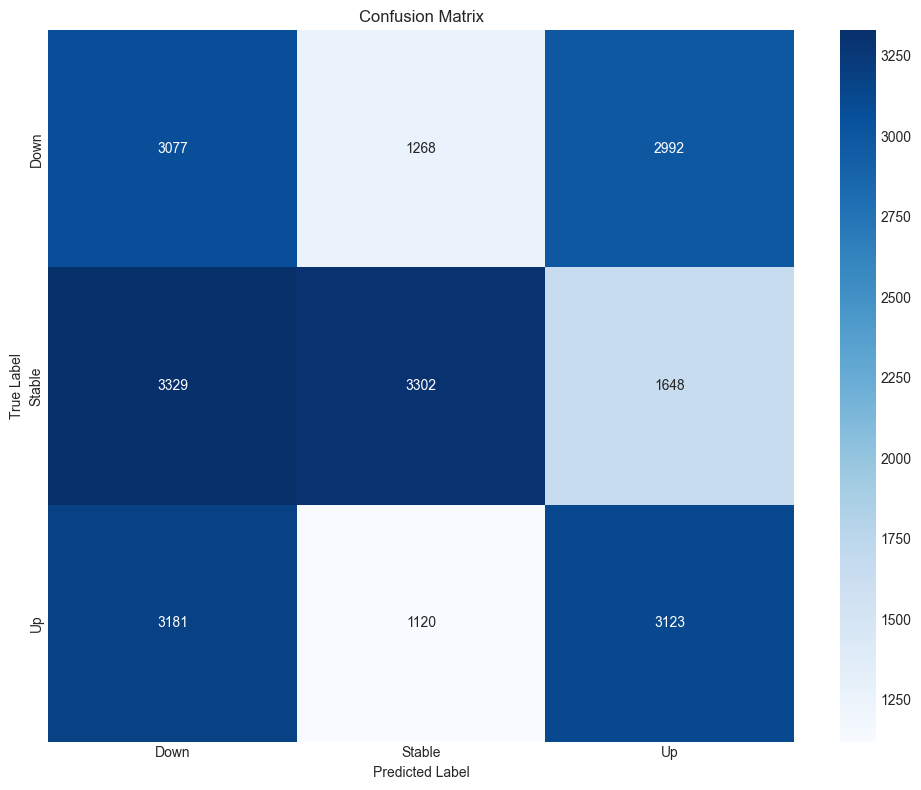

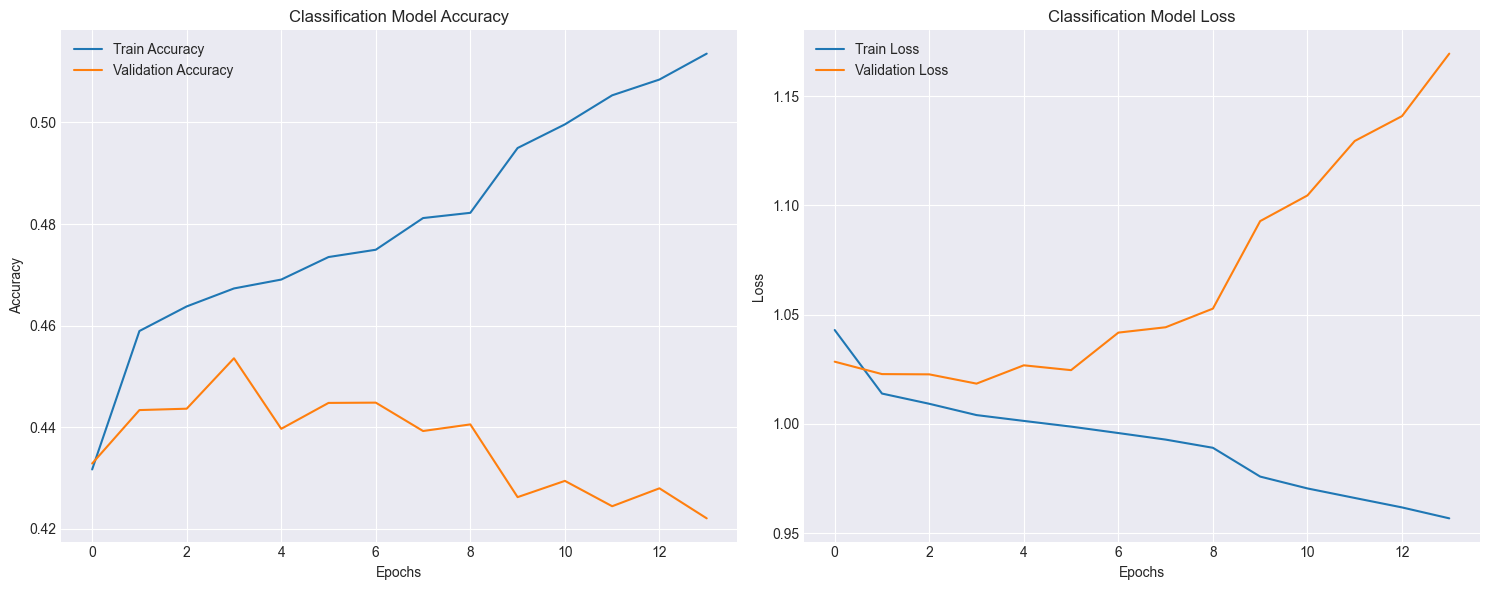

In [12]:
# Evaluate classification model
class_preds = class_model.predict(X_test_class)
class_preds_labels = np.argmax(class_preds, axis=1) - 1  # Convert back from one-hot

# Calculate accuracy
accuracy = accuracy_score(y_test_class, class_preds_labels)
print(f"\nClassification Model Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_class, class_preds_labels))

# Plot confusion matrix
class_names = ['Down', 'Stable', 'Up']
plot_confusion_matrix(y_test_class, class_preds_labels, class_names)

# Plot classification model metrics
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(class_history.history['accuracy'], label='Train Accuracy')
plt.plot(class_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Classification Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(class_history.history['loss'], label='Train Loss')
plt.plot(class_history.history['val_loss'], label='Validation Loss')
plt.title('Classification Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [16]:
# Function to predict the next 10 minutes and direction for new data
def predict_future(latest_data, reg_model, class_model, scaler, price_scaler, feature_columns, seq_length=30):
    # Ensure we have enough data
    if len(latest_data) < seq_length:
        raise ValueError(f"Need at least {seq_length} minutes of data, but got {len(latest_data)}")
    
    # Prepare the input sequence (last seq_length rows)
    sequence = latest_data[feature_columns].tail(seq_length).values
    sequence_scaled = scaler.transform(sequence)
    sequence_reshaped = sequence_scaled.reshape(1, seq_length, len(feature_columns))
    
    # Predict next 10 minutes (close prices)
    next_10_mins_scaled = reg_model.predict(sequence_reshaped)
    next_10_mins = price_scaler.inverse_transform(next_10_mins_scaled.reshape(10, 1)).flatten()
    
    # Predict direction
    direction_probs = class_model.predict(sequence_reshaped)[0]
    direction_label = np.argmax(direction_probs) - 1  # Convert from one-hot
    
    direction_text = "UP" if direction_label == 1 else "DOWN" if direction_label == -1 else "SAME"
    direction_confidence = direction_probs[np.argmax(direction_probs)] * 100
    
    # Create timestamps for the predictions
    last_timestamp = latest_data['timestamp'].iloc[-1]
    future_timestamps = [(last_timestamp + timedelta(minutes=i+1)) for i in range(10)]
    
    # Create a DataFrame with the predictions
    predictions_df = pd.DataFrame({
        'timestamp': future_timestamps,
        'predicted_close': next_10_mins,
    })
    
    # Create classification output dataframe
    class_output = pd.DataFrame({
        'direction': [direction_text],
        'confidence': [f"{direction_confidence:.2f}%"],
        'down_probability': [f"{direction_probs[0]:.4f}"],
        'stable_probability': [f"{direction_probs[1]:.4f}"],
        'up_probability': [f"{direction_probs[2]:.4f}"]
    })
    
    return predictions_df, class_output

print("Prediction function defined successfully!")

Prediction function defined successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step

Predicted Next 10 Minutes Prices:
            timestamp  predicted_close
0 2025-05-10 00:00:00       115.912117
1 2025-05-10 00:01:00       115.907990
2 2025-05-10 00:02:00       115.814796
3 2025-05-10 00:03:00       115.980301
4 2025-05-10 00:04:00       115.766418
5 2025-05-10 00:05:00       115.804283
6 2025-05-10 00:06:00       115.851631
7 2025-05-10 00:07:00       115.920174
8 2025-05-10 00:08:00       116.042641
9 2025-05-10 00:09:00       116.071648

Classification Results:
  direction confidence down_probability stable_probability up_probability
0      SAME     82.03%           0.1004             0.8203         0.0793

Prediction CSVs saved!


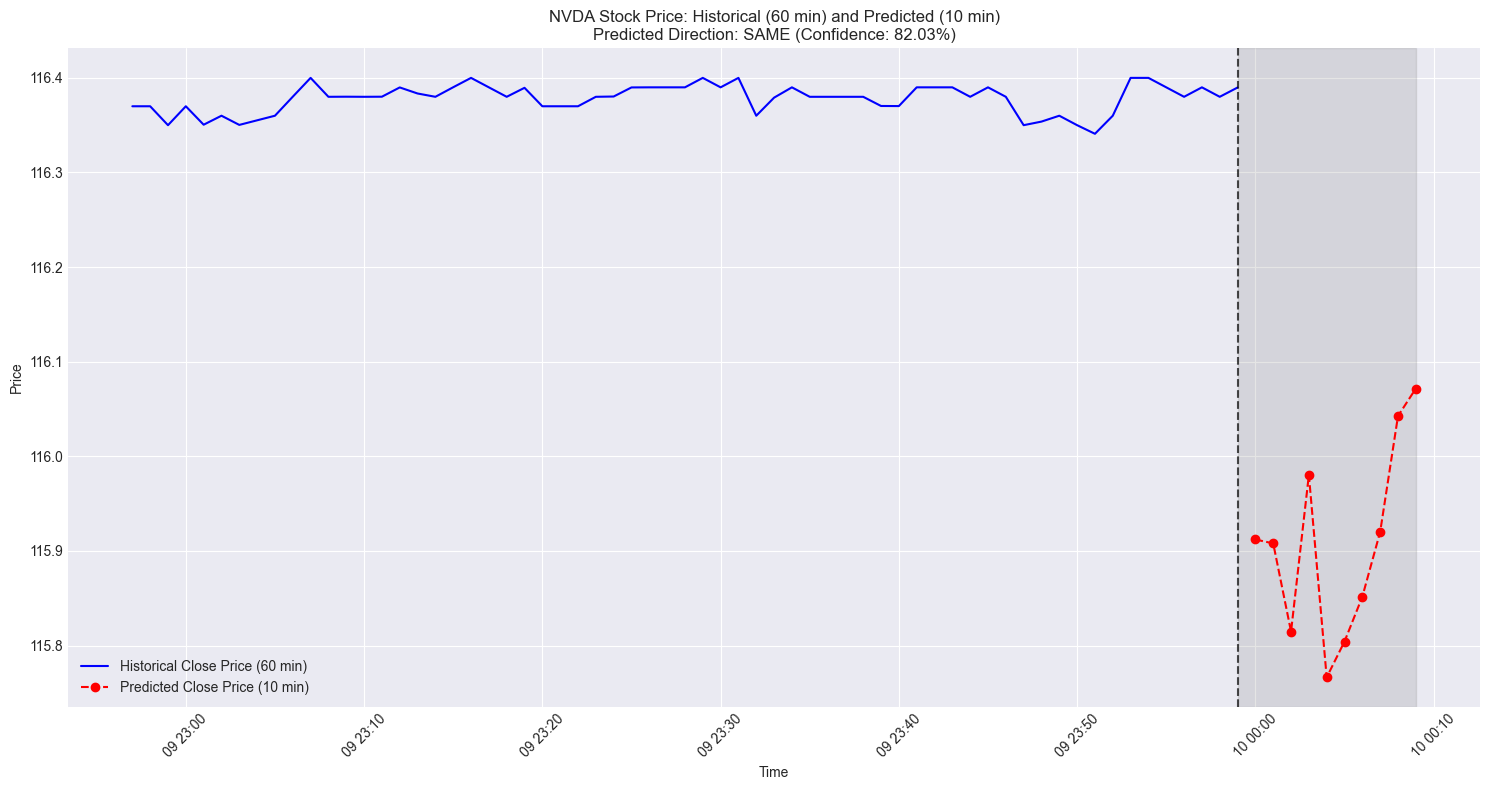

In [17]:
# Get the latest data for predictions
latest_data = df.tail(60)  # Get the latest 60 rows to ensure we have enough data for visualization

# Make predictions
predictions_df, class_output = predict_future(
    latest_data, reg_model, class_model, scaler, price_scaler, feature_columns
)

# Print the predictions
print("\nPredicted Next 10 Minutes Prices:")
print(predictions_df)

print("\nClassification Results:")
print(class_output)

# Save predictions to CSV
predictions_df.to_csv('nvda_price_predictions.csv', index=False)
class_output.to_csv('nvda_direction_prediction.csv', index=False)

print("\nPrediction CSVs saved!")

# Visualize the predictions with historical data
plt.figure(figsize=(15, 8))

# Plot historical data (last 60 minutes)
plt.plot(latest_data['timestamp'].values, latest_data['close'].values, 'b-', label='Historical Close Price (60 min)')

# Add a vertical line to separate historical and predicted data
plt.axvline(x=latest_data['timestamp'].iloc[-1], color='k', linestyle='--', alpha=0.7)

# Plot predicted data
plt.plot(predictions_df['timestamp'].values, predictions_df['predicted_close'].values, 'r--', marker='o', label='Predicted Close Price (10 min)')

# Highlight direction with background color
direction = class_output['direction'].iloc[0]
if direction == "UP":
    plt.axvspan(latest_data['timestamp'].iloc[-1], predictions_df['timestamp'].iloc[-1], alpha=0.2, color='green')
elif direction == "DOWN":
    plt.axvspan(latest_data['timestamp'].iloc[-1], predictions_df['timestamp'].iloc[-1], alpha=0.2, color='red')
else:
    plt.axvspan(latest_data['timestamp'].iloc[-1], predictions_df['timestamp'].iloc[-1], alpha=0.2, color='gray')

plt.title(f'NVDA Stock Price: Historical (60 min) and Predicted (10 min)\nPredicted Direction: {direction} (Confidence: {class_output["confidence"].iloc[0]})')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
print("=" * 50)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 50)

print("\nRegression Model Performance:")
print(f"- Overall RMSE: {rmse:.4f}")
print("- RMSE by prediction minute:")
for i, step_rmse in enumerate(rmse_per_step):
    print(f"  Minute {i+1}: {step_rmse:.4f}")

print("\nClassification Model Performance:")
print(f"- Accuracy: {accuracy:.4f}")
print("- Classification Report: See above")

print("\nLatest Prediction:")
print(f"- Direction: {class_output['direction'].iloc[0]} with {class_output['confidence'].iloc[0]} confidence")
print("- See CSVs for detailed predictions:")
print("  * nvda_price_predictions.csv")
print("  * nvda_direction_prediction.csv")


MODEL PERFORMANCE SUMMARY

Regression Model Performance:
- Overall RMSE: 0.5091
- RMSE by prediction minute:
  Minute 1: 0.3581
  Minute 2: 0.4037
  Minute 3: 0.4516
  Minute 4: 0.4591
  Minute 5: 0.5067
  Minute 6: 0.5504
  Minute 7: 0.5563
  Minute 8: 0.5592
  Minute 9: 0.5789
  Minute 10: 0.6072

Classification Model Performance:
- Accuracy: 0.4124
- Classification Report: See above

Latest Prediction:
- Direction: SAME with 82.03% confidence
- See CSVs for detailed predictions:
  * nvda_price_predictions.csv
  * nvda_direction_prediction.csv
